In [1]:
import sys
sys.path.append('../scripts')

from featherflight import FeatherFlight
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString


In [3]:
ff = FeatherFlight()

c:\Users\User\Documents\VLERICK\NOVA\adpro\group_12\prototypes\../scripts\featherflight.py:187: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
c:\Users\User\Documents\VLERICK\NOVA\adpro\group_12\.venv\Lib\site-packages\contextily\tile.py:623: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


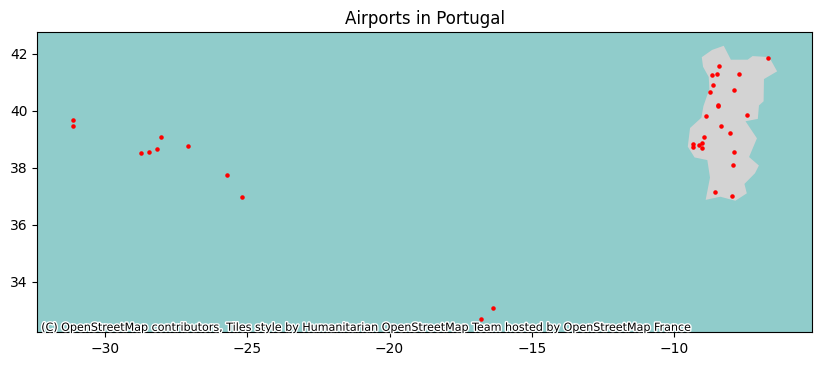

In [4]:
ff.country_airports("Portugal") 

In [151]:
country = 'United Kingdom'
cutoff = 1000
internal = False

In [152]:
country in ff.airports['Country'].unique()  

True

In [153]:
airports_ids = ff.airports[ff.airports['Country'] == country]['Airport ID']
plot_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

if internal:
    # filter routes to get the country's routes
    country_routes = ff.routes[
        (ff.routes["Source airport ID"].isin(airports_ids))
        & (ff.routes["Destination airport ID"].isin(airports_ids))
    ]

    routes_codes = country_routes[
        ["Source airport ID", "Destination airport ID"]
    ]

    # reduce the map
    plot_map = plot_map[plot_map["name"] == country]

else:
    country_routes = ff.routes[
        ff.routes["Source airport ID"].isin(airports_ids)
    ]

    routes_codes = country_routes[
        ["Source airport ID", "Destination airport ID"]
    ]

C:\Users\User\AppData\Local\Temp\ipykernel_8712\2340956121.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  plot_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


In [154]:
a = set(["1234","5678"])
b = set(["5678","1234"])
a == b

True

In [155]:
country_routes["Both Airports"] = country_routes.apply(
    lambda x: set([x["Source airport ID"], x["Destination airport ID"]]), axis=1
)

print(country_routes.shape[0])
country_routes = country_routes.drop_duplicates(subset=["Source airport ID", "Destination airport ID"])
print(country_routes.shape[0])
country_routes = country_routes.drop_duplicates(subset="Both Airports")
print(country_routes.shape[0])
country_routes = country_routes.drop(columns="Both Airports")

2663
1559
1434


C:\Users\User\AppData\Local\Temp\ipykernel_8712\2962640188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_routes["Both Airports"] = country_routes.apply(


In [156]:
country_routes["Short Haul"] = country_routes["distance_km"] < cutoff

In [157]:
country_routes["Short Haul"].value_counts(normalize=True)
annot_before = country_routes.groupby("Short Haul").agg(
    {"distance_km": ["count","sum"]})
annot_before.columns = ["Number of Routes", "Total Distance"]
annot_after = annot_before.copy()
annot_before["Total Emmisions (kg)"] = annot_before["Total Distance"] * 0.151

if False in annot_after.index:
    annot_after["Total Emmisions (kg)"] = [
        annot_after.loc[False, "Total Distance"]*0.151,
        annot_after.loc[True, "Total Distance"]*0.035,
    ]
else:
    annot_after["Total Emmisions (kg)"] = [
        annot_after.loc[True, "Total Distance"]*0.035
    ]

annot_before


,Number of Routes,Total Distance,Total Emmisions (kg)
Short Haul,,,
False,976,2.604811e+06,393326.503315
True,457,2.501692e+05,37775.543016


In [158]:
annot_after

,Number of Routes,Total Distance,Total Emmisions (kg)
Short Haul,,,
False,976,2.604811e+06,393326.503315
True,457,2.501692e+05,8755.920567


In [159]:
reduction_perc = annot_after["Total Emmisions (kg)"].sum() / annot_before["Total Emmisions (kg)"].sum() - 1

print("If we assume that each route is flown a same amount of times:")
print(f"We could reduce the emissions by {reduction_perc:.2%} by replacing short haul flights with rail")

If we assume that each route is flown a same amount of times:
We could reduce the emissions by -6.73% by replacing short haul flights with rail


In [160]:
country_routes.columns

Index(['index', 'Airline', 'Airline ID', 'Source airport', 'Source airport ID',
       'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops',
       'Equipment', 'Point_source', 'Point_destination', 'distance_km',
       'Short Haul'],
      dtype='object')

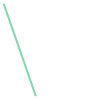

In [161]:
LineString([
    country_routes.iloc[0]["Point_source"],
    country_routes.iloc[0]["Point_destination"]])

In [162]:
geometry = country_routes.apply(
    lambda x: LineString([x["Point_source"][::-1], x["Point_destination"][::-1]])
    if pd.notnull(x["Point_source"]) and pd.notnull(x["Point_destination"])
    else np.nan,
    axis=1
)

In [163]:
print((12, 13)[::-1])

(13, 12)


In [164]:
flights = gpd.GeoDataFrame(country_routes, geometry=geometry)

In [170]:
import folium



title = f"Flights from {country}"
reduction = "".join([
    f"We could reduce the emissions by {reduction_perc:.2%} ",
    f"(from {annot_before['Total Emmisions (kg)'].sum():,.0f} to {annot_after['Total Emmisions (kg)'].sum():,.0f} kgCO2)",
    " by replacing short haul flights with rail."
])

title_html = """
    <h1 align="left" style="font-size:20px"><b>{}</b></h1>
    <h2 align="left" style="font-size:16px"><b>{}</b></h2>
""".format(title, reduction)   

# set the figure size of the map
m = folium.Map(width=900,height=400, zoom_start=1)
m.get_root().html.add_child(folium.Element(title_html))

m = plot_map.explore(
    m=m,
    column="name",
    scheme="naturalbreaks",
    tooltip="name",
    name="Country",
    legend=False
)

flights[flights["Short Haul"]].explore(
    m=m,
    tooltip=[
        "Source airport",
        "Destination airport",
        "distance_km",
        "Short Haul",
    ],  
    tooltip_kwds=dict(labels=True),
    style_kwds=dict(color="blue",weight=1, opacity=0.3),
    name="Short Haul Routes \n"+
    f"({annot_before.loc[True, "Total Distance"]:,.0f}km for {annot_before.loc[True, "Number of Routes"]:,} routes)"
)

if False in flights["Short Haul"].unique():
    flights[~flights["Short Haul"]].explore(
        m=m,
        tooltip=[
            "Source airport",
            "Destination airport",
            "distance_km",
            "Short Haul",
        ],  
        tooltip_kwds=dict(labels=True),
        style_kwds=dict(color="red",weight=1, opacity=0.3),
    name="Long Haul Routes \n"+
    f"({annot_before.loc[False, "Total Distance"]:,.0f}km for {annot_before.loc[False, "Number of Routes"]:,} routes)"
)

folium.TileLayer("CartoDB positron", show=False).add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

ploted_airports = ff.airports[
    np.logical_or(
        ff.airports["Airport ID"].isin(routes_codes["Source airport ID"]),
        ff.airports["Airport ID"].isin(routes_codes["Destination airport ID"]),
    )
]

sw = ploted_airports[['Latitude', 'Longitude']].min().values.tolist()
ne = ploted_airports[['Latitude', 'Longitude']].max().values.tolist()

m.fit_bounds([sw, ne]) 
m

In [166]:
        # plot
        _, axis = plt.subplots(figsize=(10, 10))
        plot_map.plot(ax=axis, color="lightgrey", label="World Map")
        gdf.plot(ax=axis, alpha=0.1, linewidth=0.5, label=" ALL Flights")
        short_haul_gdf.plot(ax=axis, color="blue", alpha=0.5, linewidth=1, label = "Short Haul Flights")
        long_haul_gdf.plot(ax=axis, color="red", alpha=0.5, linewidth=1, label = "Long Haul Flights")
        
        plt.title(f"Flights from {country}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.annotate(f"Short-haul routes: {number_short_haul_routes}\nTotal distance: {total_distance_short_haul:.2f} km\nEstimated flight emission reduction (internal and external flights taken into account): {total_emission_reduction:.2f} kg CO2e", 
                    xy=(1, 0), xycoords='axes fraction',
                    xytext=(-20, 20), textcoords='offset points',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
                    fontsize=12)
        plt.legend()
        plt.show()

        #National rail emits around 35 grams per kilometer. A short-haul flight emits 151 grams. So the footprint of taking the train is around 23% of a flight: [ 35 / 151 * 100 = 23,17%].
        #Data source: UK Government, Department for Energy Security and Net Zero


NameError: name 'plt' is not defined